In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import PIL.ExifTags
import PIL.Image
import json
import open3d as o3d
from sklearn.decomposition import PCA
from tqdm import tqdm

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
with open('camera_model.json', 'r') as f:
    file = json.load(f)
    print(file)

[{'model': 'SONY_ZV1', 'cmos_width': 13.2, 'cmos_height': 8.8}, {'model': 'Canon PowerShot SX740 HS', 'cmos_width': 6.17, 'cmos_height': 4.55}]


In [3]:
img1 = cv.imread("data\small scale\column_left.JPG", cv.IMREAD_GRAYSCALE)
img2 = cv.imread("data\small scale\column_right.JPG", cv.IMREAD_GRAYSCALE)

In [4]:

img = PIL.Image.open('data\IMG_8048.JPG')
exif_data = img._getexif()

exif = {
    PIL.ExifTags.TAGS[k]: v
    for k, v in img._getexif().items()
    if k in PIL.ExifTags.TAGS
}

print("by metadata from image exif, f = {} mm, cx = {} pixels, cy = {} pixels".format(exif['FocalLength'], exif['ExifImageHeight'], exif['ExifImageWidth']))


FileNotFoundError: [Errno 2] No such file or directory: 'data\\IMG_8048.JPG'

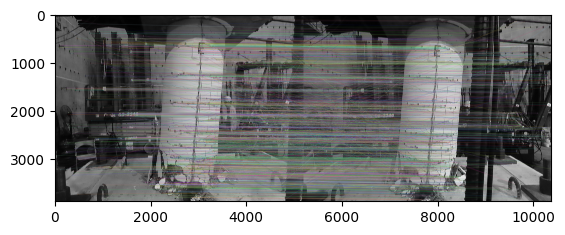

(<matplotlib.image.AxesImage at 0x2b1dccd3c10>, None)

In [5]:
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
pts1 = []
pts2 = []
good_matches = []
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.75*n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)
        good_matches.append([m])
pts1 = np.asarray(pts1)
pts2 = np.asarray(pts2)

img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,good_matches,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()

In [49]:
camera_intrinsics = np.array([
    [1000, 0, 2500],
    [0, 1000, 2000],
    [0, 0, 1]
])
E, mask = cv.findEssentialMat(pts1, pts2, camera_intrinsics)
_, R, t, mask = cv.recoverPose(E, pts1, pts2, camera_intrinsics)
# obtained R, t, construct P
# [x] x PX = 0
# [x] and P are known
# solve for X
# triangulation


In [218]:
pcd = o3d.io.read_point_cloud("./data/book.ply")
voxel_size = 0.1
voxel_down_pcd = pcd.voxel_down_sample(voxel_size=voxel_size)
print(voxel_down_pcd)

PointCloud with 16845 points.


In [211]:
o3d.visualization.draw_geometries([voxel_down_pcd])

In [10]:
def display_inlier_outlier(cloud, ind):
    inlier_cloud = cloud.select_by_index(ind)
    outlier_cloud = cloud.select_by_index(ind, invert=True)

    print("Showing outliers (red) and inliers (gray): ")
    outlier_cloud.paint_uniform_color([1, 0, 0])
    inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])

In [11]:
print("Radius oulier removal")
filtered_pcd, ind = voxel_down_pcd.remove_radius_outlier(nb_points=16, radius=0.05)
print(filtered_pcd)
display_inlier_outlier(voxel_down_pcd, ind)

Radius oulier removal
PointCloud with 25036 points.
Showing outliers (red) and inliers (gray): 


In [12]:
o3d.visualization.draw_geometries([filtered_pcd])

In [203]:
def extract_plane_points(pcd, voxel_size):
    pcd.paint_uniform_color([0,1,0])
    pcd_tree = o3d.geometry.KDTreeFlann(pcd)
    pca = PCA(n_components=3, svd_solver='full')
    linearity_list = []
    planarity_list = []
    eigen_value_list = []
    eigenvector_list = []
    for i in tqdm(np.arange(np.asarray(pcd.points).shape[0])):
        [k, idx, _] = pcd_tree.search_hybrid_vector_3d(pcd.points[i], 3*voxel_size, 30)
        if (k > 3):
            pca.fit(np.asarray(pcd.points)[idx[1:]])
            eigenvalue = (pca.explained_variance_)
            eigenvector = pca.components_

            # extract hand-crafted feature by eigen value
            linearity = (eigenvalue[0] - eigenvalue[1]) / eigenvalue[0]
            planarity = (eigenvalue[1] - eigenvalue[2]) / eigenvalue[0]
            alpha_3d = eigenvalue[2] / eigenvalue[0]
            omnivariance = np.power(eigenvalue[0] * eigenvalue[1] * eigenvalue[2], 1/3)

            assert linearity + planarity + alpha_3d - 1 < 0.001        

        else:
            linearity = 0.33
            planarity = 0.33
            alpha_3d = 0.33

        linearity_list.append(linearity)
        planarity_list.append(planarity)

        eigen_value_list.append(eigenvalue)
        eigenvector_list.append(eigenvector)
    

    plane_points_list = []
    plane_point_v_list = []
    plane_points_ev_list = []

    for i in tqdm(np.arange(len(linearity_list))):
        if (planarity_list[i] > 0.4):
            plane_points_list.append(i)
            plane_point_v_list.append(eigen_value_list[i])
            plane_points_ev_list.append(eigenvector_list[i])
    plane_points_list = np.array(plane_points_list)
    plane_point_v_list = np.array(plane_point_v_list)
    plane_points_ev_list = np.array(plane_points_ev_list)
    return plane_points_list, plane_point_v_list, plane_points_ev_list

def pick_points(pcd):
    print("")
    print(
        "1) Please pick 2 points on each planes using [shift + left click]"
    )
    print("   Press [shift + right click] to undo point picking")
    print("2) After picking points, press 'Q' to close the window")
    vis = o3d.visualization.VisualizerWithEditing()
    vis.create_window()
    vis.add_geometry(pcd)
    vis.run()  # user picks points
    vis.destroy_window()
    print("")
    return vis.get_picked_points()

def find_similar_ev_points(src_ev: np.ndarray, tgt_points_id: np.ndarray, tgt_evs: np.ndarray):
    '''Given a source point eigen vector, return the point id(s) in target points that have similar first eigenvector
    
    Args:
        src_ev (np.ndarray): source eigen vector
        tgt_points_id (np.ndarray):  target points id(s) from original pcd
        tgt_evs (np.ndarray):    the eigen vectors of target points
    
    Returns:
        np.ndarray: point id(s) that have similar first eigen vector
    '''
    deg_threshold = 5
    C_list = []
    src_ev1 = src_ev[0]

    for index in range(len(tgt_evs)):
        tgt_ev1 = tgt_evs[index][0]
        if (np.abs(np.dot(src_ev1, tgt_ev1)) > np.cos(deg_threshold*np.pi/180)):
            C_list.append(tgt_points_id[index])
    return np.array(C_list)

def angle_between_plane(n1: np.ndarray, n2: np.ndarray):
    angle = np.arccos(np.abs(np.dot(n1, n2) / (np.linalg.norm(n1) * np.linalg.norm(n2)))) * 180 / np.pi
    return angle

def measure_angle_from_planes(filtered_pcd, plane_points_ev_list: np.ndarray, plane_points_id_list: np.ndarray):
    
    plane_pcd = o3d.geometry.PointCloud()
    plane_pcd.points = o3d.utility.Vector3dVector(np.asarray(filtered_pcd.points)[plane_points_id_list])
    points = pick_points(plane_pcd)

    assert len(points) == 2, 'Please pick two points.'
    plane1_point_id, plane2_point_id = points

    plane_points_list_1 = find_similar_ev_points(plane_points_ev_list[plane1_point_id], plane_points_id_list, plane_points_ev_list)
    plane_points_list_2 = find_similar_ev_points(plane_points_ev_list[plane2_point_id], plane_points_id_list, plane_points_ev_list)
    print("plane 1 point's number = {}, plane 2 point's number = {}".format(len(plane_points_list_1), len(plane_points_list_2)))

    ground_pcd_1 = o3d.geometry.PointCloud()
    ground_pcd_1.points = o3d.utility.Vector3dVector(np.asarray(filtered_pcd.points)[plane_points_list_1])
    
    segment_plane1 = ground_pcd_1.segment_plane(distance_threshold=0.01, ransac_n=3, num_iterations=1000)
    n1 = segment_plane1[0][:3]

    ground_pcd_2 = o3d.geometry.PointCloud()
    ground_pcd_2.points = o3d.utility.Vector3dVector(np.asarray(filtered_pcd.points)[plane_points_list_2])
    
    segment_plane2 = ground_pcd_2.segment_plane(distance_threshold=0.01, ransac_n=3, num_iterations=1000)
    n2 = segment_plane2[0][:3]

    print("n1 = {}, n2 = {}".format(n1, n2))

    angle = angle_between_plane(n1, n2)

    return angle

In [219]:
plane_points_id_list, plane_points_v_list, plane_points_ev_list = extract_plane_points(voxel_down_pcd, voxel_size)

100%|██████████| 16845/16845 [00:00<00:00, 2103896.46it/s]


In [224]:
angle = measure_angle_from_planes(voxel_down_pcd, plane_points_ev_list, plane_points_id_list)
print("angle between plane = {:.2f} deg".format(angle))


1) Please pick 2 points on each planes using [shift + left click]
   Press [shift + right click] to undo point picking
2) After picking points, press 'Q' to close the window
[Open3D INFO] No point has been picked.
[Open3D INFO] Picked point #4342 (2.9, -2.1, -7.0) to add in queue.
[Open3D INFO] Picked point #4342 (2.9, -2.1, -7.0) to add in queue.

plane 1 point's number = 185, plane 2 point's number = 185
n1 = [-0.01679761  0.97114854  0.23788307], n2 = [-0.01399571  0.97325351  0.22930705]
angle between plane = 0.53 deg


In [175]:
plane_pcd = o3d.geometry.PointCloud()
plane_pcd.points = o3d.utility.Vector3dVector(np.asarray(filtered_pcd.points)[plane_points_id_list])
plane_pcd.paint_uniform_color([0, 1,0])
filtered_pcd.paint_uniform_color([1,0,0])
# plane_pcd.colors = o3d.utility.Vector3dVector(np.asarray(filtered_pcd.colors)[plane_points_id_list])
o3d.visualization.draw_geometries([plane_pcd, filtered_pcd])

IndexError: index 25036 is out of bounds for axis 0 with size 25036

In [97]:
C_list = find_similar_ev_points(plane_points_ev_list[19585], plane_points_id_list, plane_points_ev_list)
print("number of similar normal = {}".format(len(C_list)))
ground_pcd = o3d.geometry.PointCloud()
ground_pcd.points = o3d.utility.Vector3dVector(np.asarray(filtered_pcd.points)[C_list])
# ground_pcd.paint_uniform_color([1,0,0])
o3d.visualization.draw_geometries([ground_pcd])

number of similar normal = 93


In [66]:
segment_plane1 = ground_pcd.segment_plane(distance_threshold=0.02, ransac_n=10, num_iterations=100)
params1 = segment_plane1[0]
print("the equation of plane is {:.4f}x + {:.4f}y +{:.4f}z +{:.4f} = 0".format(params1[0], params1[1], params1[2], params1[3]))

the equation of plane is -0.0080x + 0.9836y +0.1801z +2.1610 = 0


In [88]:
segment_plane2 = ground_pcd.segment_plane(distance_threshold=0.02, ransac_n=10, num_iterations=100)
params2 = segment_plane2[0]
print("the equation of plane is {:.4f}x + {:.4f}y +{:.4f}z +{:.4f} = 0".format(params2[0], params2[1], params2[2], params2[3]))

the equation of plane is 0.7468x + -0.1009y +0.6574z +1.9283 = 0


In [89]:
angle = angle_between_plane(params1, params2)
print(angle*180/np.pi)

89.62415470255648
